### A starting notebook for 1D advection

The next line activates the environment in which we are working on HW3. It is assumed that you already generated this environment, per the instructions in the document *UsingJulia.pdf*

In [3]:
using Pkg
Pkg.activate("/Users/jeff/Dropbox/MAE250H/julia/HW3")

"/Users/jeff/Dropbox/MAE250H/julia/HW3/Project.toml"

Load some useful packages, including our own!

In [4]:
using Revise
using Plots
using FFTW
using HW3

### 1-D Advection

The goal of this problem is to solve

$$ \dfrac{\partial u}{\partial t} + c \dfrac{\partial u}{\partial x} = 0$$

on domain $x \in [0,L]$ subject to periodic boundary conditions (period $L$) and initial condition

$$ u(x,0) = \dfrac{1}{\sqrt{\pi\sigma^2}} \mathrm{e}^{-(x-x_0)^2/\sigma^2} \cos[k_0(x-x_0)]$$

where $x_0 = L/2$. We will keep $L = 1$ and $c = 1$, which is equivalent to non-dimensionalizing by these parameters. The objective is to explore dispersion and dissipation that result from the finite difference method. We will use cell-centered data for this problem.

Set up the physical domain

In [5]:
L = 1  # length of domain
xL = 0.0  # coordinate of left side of domain

0.0

Set the physical parameters

In [6]:
c = 1  # wave speed

1

Define the right-hand side functions. These can be supplied to the RK method to set up a time integrator.

In [7]:
# RHS for central difference method
function advect1d_periodic_cd2(u::HW3.CellData1D{N},t::Real) where {N}
    du = HW3.CellData1D(u)
    
    # copy interior data at the ends of domain into opposite ghosts... this enforces the periodic boundary conditions
    u[1]   = u[N+1]
    u[N+2] = u[2]
    
    
    # translate the cell data to edge data (a simple averaging of neighboring cell centers)
    # then compute divergence of this edge data to get central difference at cell centers
    q = HW3.EdgeData1D(u)
    HW3.translate!(q,u)
    du = HW3.divergence(q)
    
    return -c/Δx*du
end

# RHS for backward difference method
function advect1d_periodic_bd1(u::HW3.CellData1D{N},t::Real) where {N}
    du = HW3.CellData1D(u)
    
    # copy interior data at the ends of domain into opposite ghosts... this enforces the periodic boundary conditions
    u[1]   = u[N+1]
    u[N+2] = u[2]
    
    # Compute the gradient at edges, then copy edge data into cell centers immediately to the right
    # to obtain backward differencing. edge i to cell i+1
    q = HW3.gradient(u)
    du[2:N+1] .= q[1:N]     
    
    return -c/Δx*du
end

advect1d_periodic_bd1 (generic function with 1 method)

Choose the discretization and set up the mapping to physical space

In [8]:
N = 100 # number of interior cells. This should be varied and explored.

100

In [9]:
Δx = L/N
# Note that these are functions, not arrays.
xedge(i_e::Real) = xL + (i_e - 1)*Δx
xcell(i_c::Real) = xL + (i_c - 1.5)*Δx
i_c_int = 2:N+1 # interior cells
i_e = 1:N+1 # edges

1:101

Choose values for k0 between 0 and π/Δx

In [10]:
k0 = 0.05*π/Δx  # Center wavenumber of wave packet
σ = 0.25*L  # Width of wave packet. Keep this at 0.25L to ensure a tight group.
x0 = 0.5*L  # Initial location of center of wave packet. Keep this at 0.5L

0.5

Define the waveform of wave packet

In [11]:
uwave(x) = 1/sqrt(π*σ^2)*exp(-(x-x0)^2/σ^2)*cos(k0*(x-x0))

uwave (generic function with 1 method)

Set the initial condition of state vector

In [12]:
u0 = HW3.CellData1D(N)
u0[i_c_int] .= uwave.(xcell.(i_c_int));

Plot the initial wave packet

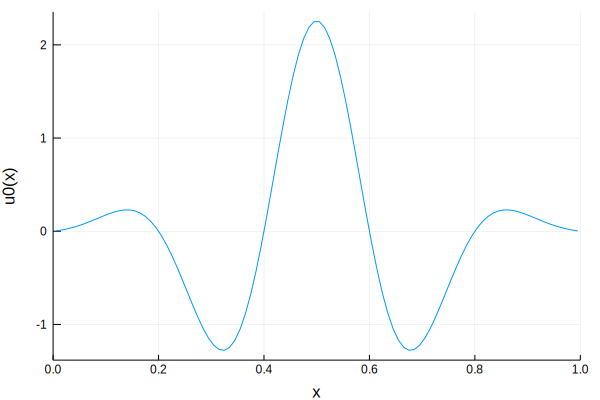

In [13]:
plot(xcell.(i_c_int),u0[i_c_int],xlim=(0,L),xlabel="x",ylabel="u0(x)",legend=false)

Let's plot the power spectrum of the wave packet. Here we are just looking at the placement of the peak relative to $\pi/\Delta x$, the maximum grid wavenumber.

In [14]:
using FFTW

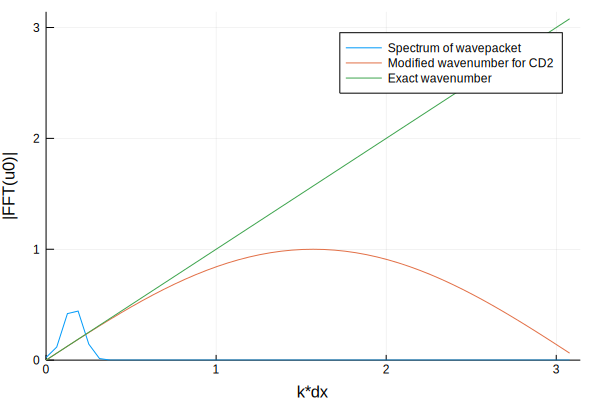

In [15]:
û₀ = fft(u0)/N
k = 1:Int(N/2)
kdx = (k.-1)*2π/N
plot(kdx,abs.(û₀[k]),xlim=(0,π),ylim=(0,π),xlabel="k*dx",ylabel="|FFT(u0)|",label="Spectrum of wavepacket")
plot!(kdx,sin.(kdx),label = "Modified wavenumber for CD2")
plot!(kdx,kdx,label="Exact wavenumber")

Set up the time step and the integrator.
* To use 4th-order Runge-Kutta, set `rk = HW3.RK4`
* To use forward Euler, set `rk = HW3.Euler`.

In [25]:
Co = 0.01 # Courant number. Keep this small to ensure that there is negligible time marching error
Δt = Δx/c 
rk = HW3.RK(u0,Δt,advect1d_periodic_cd2;rk=HW3.RK4)

Order-4 RK integator with
   State of type HW3.CellData1D{100}
   Time step size 0.01


Integrate this to final time of 0.25. Store the data in arrays.

In [26]:
tf = 0.5
nsteps = ceil(Int,tf/Δt)
t = 0.0
u = deepcopy(u0)
uarray = [deepcopy(u)]
tarray = [t]
for j = 1:nsteps
    t, u = rk(t,u)
    push!(uarray,deepcopy(u))
    push!(tarray,t)
end

Evaluate exact solution at the end of the integration interval. 

In [27]:
texact = tarray[end]
uexact = HW3.CellData1D(u)
for i in i_c_int
    x̃ = xcell(i)-c*texact
    x̃ = mod(x̃,L) # this ensures periodicity
    uexact[i] = uwave(x̃)
end

Compare the numerical solution with the exact solution

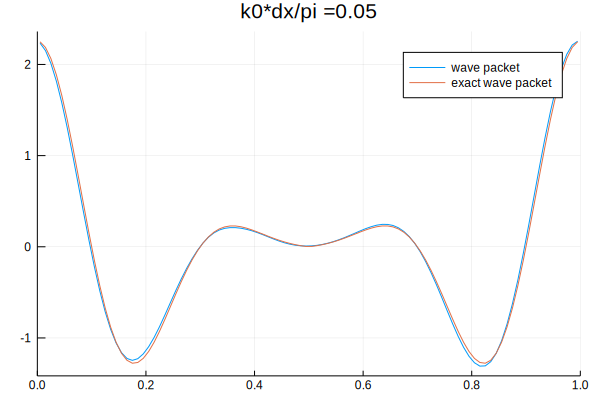

In [28]:
plot(xcell.(i_c_int),uarray[end][i_c_int],label="wave packet",xlim=(0,1))
plot!(xcell.(i_c_int),uexact[i_c_int],label="exact wave packet",title=string("k0*dx/pi =",k0*Δx/π))